# 19. Intersubject Variability

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pingouin import ancova

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

## Table of Contents
- [Stability](#stable)
    - Stability across movies
    - Stability across subjects

In [10]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

#### Intersubject variability

##### Generate gradients from subsets of subjects per movie

In [11]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

In [20]:
total_series = load('./data/fmri_414_series.pkl')

all_grads = {mname:  {} for mname in total_series}
for mname in total_series:
    for _id in total_series[mname]:
        tmp_series = total_series[mname][_id]
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_
        
        fscore = D(grad.mean(axis=0),grad)
        all_grads[mname][_id] = fscore


In [38]:
tmp_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

rest_grads = {}
for _id in tmp_grads:
    grad = tmp_grads[_id]
    fscore = D(grad.mean(axis=0),grad)
    rest_grads[_id] = fscore

all_grads['Rest'] = rest_grads

In [43]:
import seaborn as sns

In [48]:
for mname in total_series:
    print('{} {}'.format(mname,np.asarray(list(all_grads[mname].values())).std(axis=0).mean()))

ToClaireFromSonny 73.32843517718202
TheSecretNumber 79.05860354236911
Chatter 79.3893384200647
LessonLearned 64.29560919202379
Payload 68.69665990411568
AfterTheRain 114.45865185437147
Superhero 124.33116472175658
Sintel 91.08081465766091
TearsOfSteel 83.2014139364806
BetweenViewing 78.24000306534427
BigBuckBunny 150.4308736101909
Rest 120.10230600686569
YouAgain 76.1253626221606
Spaceman 120.86673278738135
FirstBite 68.40935934337219


(array([  1.,   0.,   1.,   0.,   0.,  10.,  55., 160.,  76., 111.]),
 array([-653.07014627, -567.27154496, -481.47294366, -395.67434236,
        -309.87574105, -224.07713975, -138.27853844,  -52.47993714,
          33.31866417,  119.11726547,  204.91586678]),
 <BarContainer object of 10 artists>)

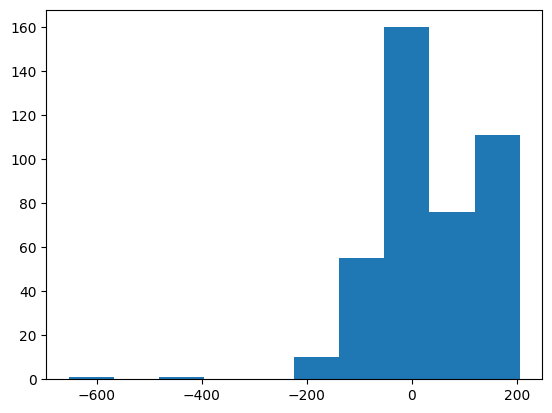

In [53]:
plt.hist(np.asarray(list(all_grads['BigBuckBunny'].values())).std(axis=0) - np.asarray(list(all_grads['Rest'].values())).std(axis=0))

<AxesSubplot:ylabel='Density'>

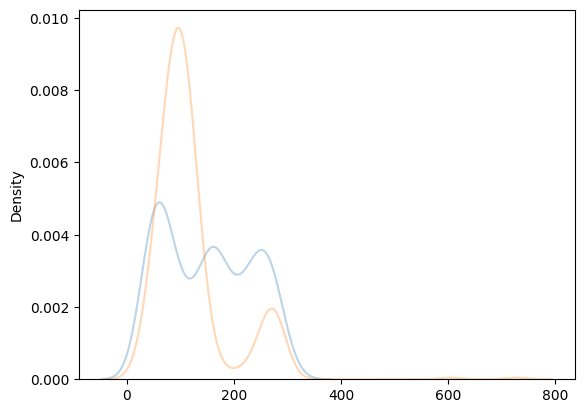

In [51]:
sns.kdeplot(np.asarray(list(all_grads['BigBuckBunny'].values())).std(axis=0), alpha=0.3)
sns.kdeplot(np.asarray(list(all_grads['Rest'].values())).std(axis=0), alpha=0.3)

##### Visualize Variance across Sampled Gradients for each Movies

In [7]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_grad/'):
    samples_grad.append(load('./resources/sample_grad/'+sample))
    samples_label.append(sample.split('_')[0])

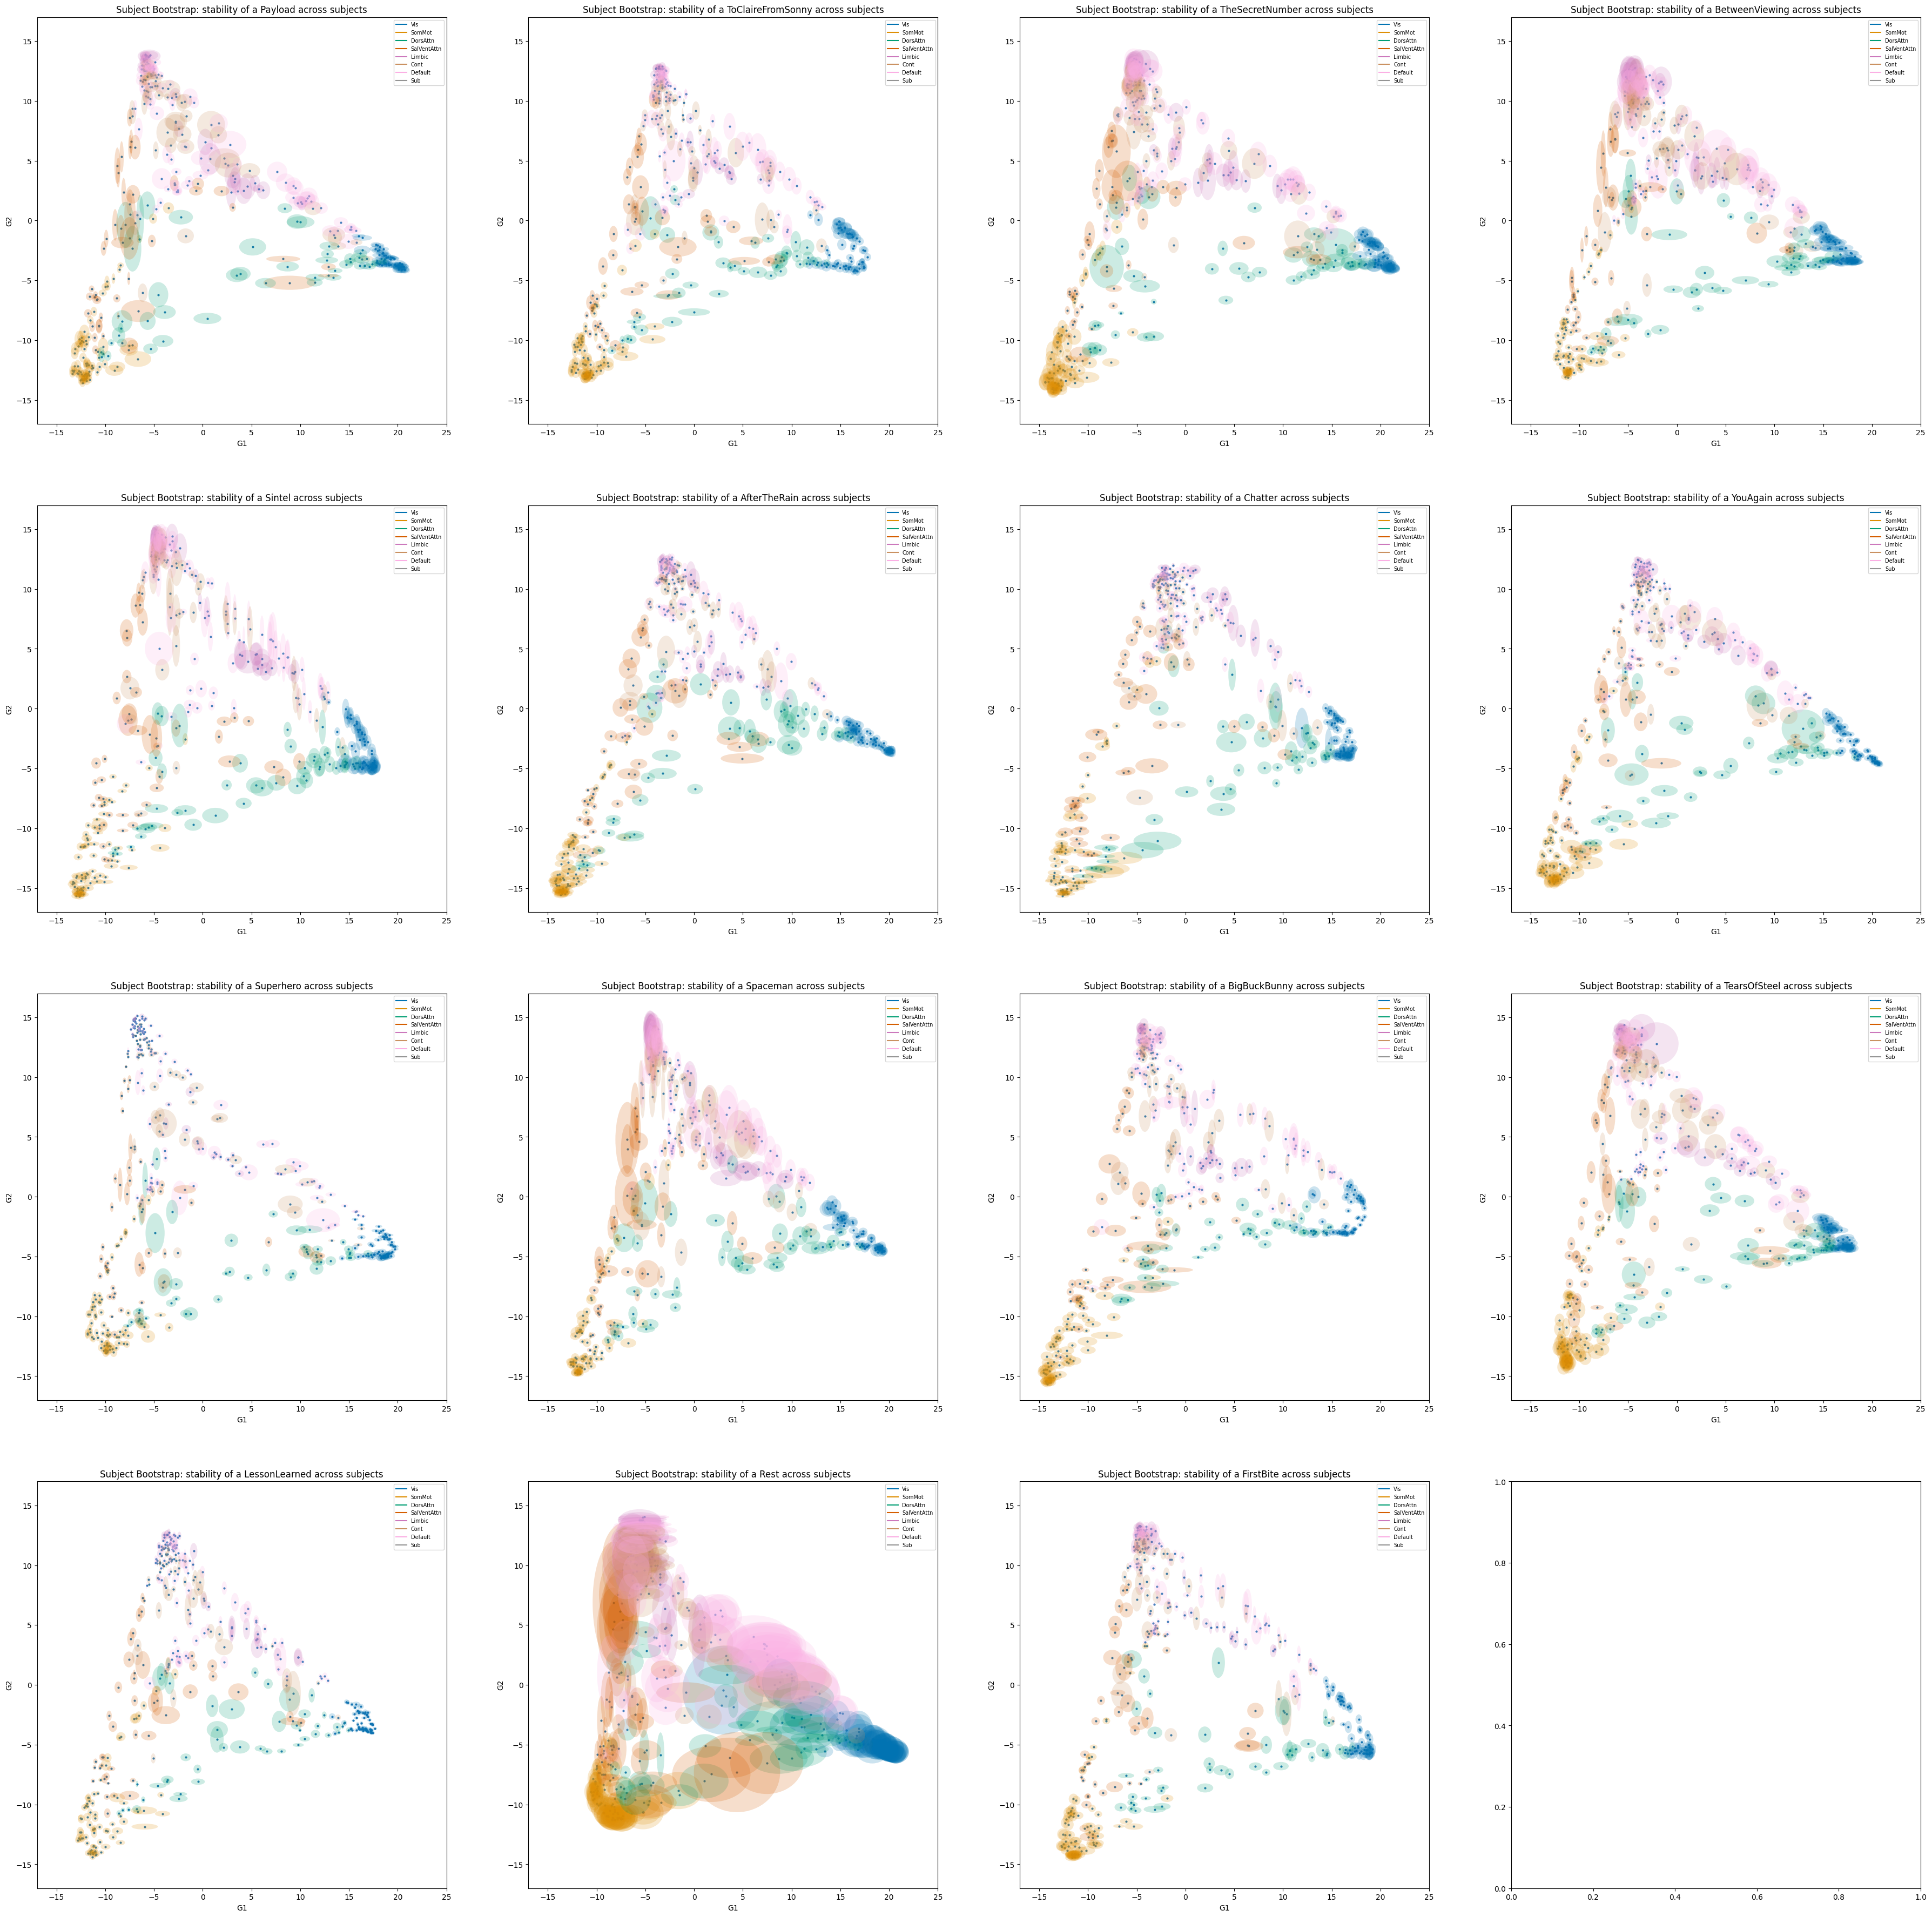

In [6]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}
# colors         = {'Vis': my_cmap.colors[idx], 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


fig, axes = plt.subplots(4,4, figsize=(45,45))

refs = []
for k in range(len(samples_grad)):
    _,ref        = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    refs.append(ref)

ref_align, _ , _ = procrustes_align(refs)

aligned_samples = []
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    aligned,_        = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    ref = ref_align[k]
    axes[row,col].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.2)

        # axes[row,col].add_artist(cc)
        axes[row,col].add_patch(ellipse)

    axes[row,col].set_title("Subject Bootstrap: stability of a {} across subjects".format(samples_label[k]), size=12)

    CN      = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in CN]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,17)
    axes[row,col].set_xlabel('G1')
    axes[row,col].set_ylabel('G2')

plt.show()

##### Quantify Variance across Sampled Gradients for each Movies using ANOVA

In [11]:
idx = 13
jdx = 4

rest_grads,_,s = procrustes_align(samples_grad[idx], n_iter=100)
rest_grads     = np.asarray(rest_grads)

sintel_grads,_,s = procrustes_align(samples_grad[jdx],  n_iter=100)
sintel_grads     = np.asarray(sintel_grads)

bootstrap_rest   = rest_grads.std(axis=0)[:,0]
bootstrap_sintel = sintel_grads.std(axis=0)[:,0]

In [14]:
# Performing two-way ANOVA
yeo2region = load('./resources/yeo7region400.pkl')
networks   = list(yeo2region.keys())

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    df['score'] += list(bootstrap_rest[yeo2region[n]])
    df['score'] += list(bootstrap_sintel[yeo2region[n]])
    df['cond']  += ['rest'] * len(yeo2region[n])
    df['cond']  += ['movie'] * len(yeo2region[n])
    df['network'] += [n] * 2 * len(yeo2region[n])
    
df = pd.DataFrame.from_dict(df)


model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     df &      sum\_sq &     mean\_sq &           F &         PR(>F) \\
\midrule
C(cond)            &    1.0 &  241.658218 &  241.658218 &  701.944217 &  4.910491e-111 \\
C(network)         &    6.0 &   24.499767 &    4.083294 &   11.860739 &   9.133746e-13 \\
C(cond):C(network) &    6.0 &   36.687572 &    6.114595 &   17.761055 &   2.294153e-19 \\
Residual           &  786.0 &  270.596088 &    0.344270 &         NaN &            NaN \\
\bottomrule
\end{tabular}



Plot interaction terms details

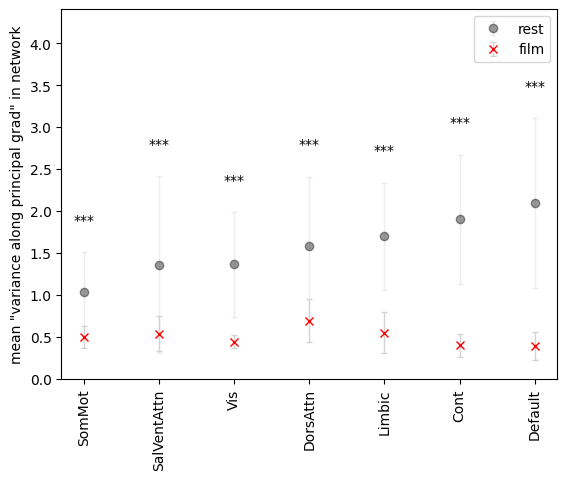

In [35]:
# plot of scatter
rest_df  = df[df.cond == 'rest']
movie_df = df[df.cond == 'movie']
rest_arr  = []
movie_arr = []
for n in networks:
    cur = np.array(rest_df[rest_df.network==n]['score'])
    rest_arr.append([cur.mean(), cur.std()])
    
    cur = np.array(movie_df[movie_df.network==n]['score'])
    movie_arr.append([cur.mean(), cur.std()])
    
rest_arr  = np.asarray(rest_arr)
movie_arr = np.asarray(movie_arr)

order     = np.argsort(rest_arr[:,0])
rest_arr  = rest_arr[order]
movie_arr = movie_arr[order]

plt.errorbar(list(range(rest_arr.shape[0])), rest_arr[:,0], yerr=rest_arr[:,1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.4, label='rest');

plt.errorbar(list(range(movie_arr.shape[0])), movie_arr[:,0], yerr=movie_arr[:,1], fmt='x', color='red',
             ecolor='lightgray', elinewidth=1, capsize=2, label='film');

# two-sample t-test
import scipy.stats as stats

lheight = []
for idx,n in enumerate(np.array(networks)[order]):
    pval = stats.ttest_ind(a=np.array(rest_df[rest_df.network==n]['score']), 
                    b=np.array(movie_df[movie_df.network==n]['score'])
                    , equal_var=False).pvalue
    c1, c2, c3 = int(pval < 0.01), int(pval < 0.005), int(pval < 0.001) 
    nbstars = c1 + c2 + c3
    height  = max(rest_arr[idx,0] + rest_arr[idx,1],
                  movie_arr[idx,0] + movie_arr[idx,1]) + 0.3
    lheight.append(height)
    plt.text(idx, height, 
             '*' * nbstars, ha='center', va='bottom')
    
    
plt.ylabel('mean "variance along principal grad" in network')
# plt.xlabel('networks')
plt.xticks(list(range(rest_arr.shape[0])), 
           np.array(networks)[order], rotation=90)
plt.ylim(0,max(lheight) + 1)
plt.legend()
plt.show()